In [ ]:
import cv2
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pylab as plt

from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread

import tensorflow as tf
from tensorflow import keras

import keras.backend as K
from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline

In [ ]:
imagePatches = glob('/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)

In [ ]:
for filename in imagePatches[0:7]:
    print(filename)

../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x151_y1051_class0.png
../input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y901_class0.png


In [ ]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
        class0.append(filename)
    else:
        class1.append(filename)

In [ ]:
print("Class 0 :", len(class0))
print("Class 1 :", len(class1))

Class 0 : 198738
Class 1 : 78786


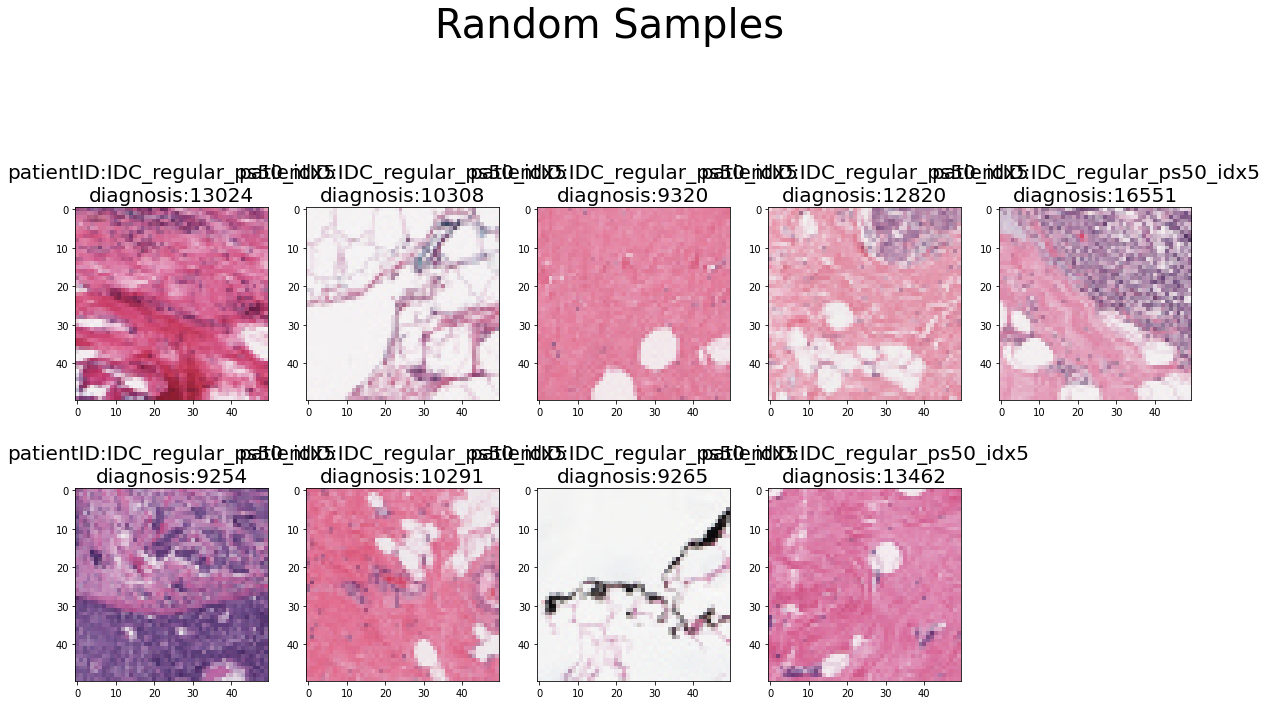

In [ ]:
from random import choice
fig,axes = plt.subplots(figsize=(20,25))
  
ran_sample = [choice(class0)for x in range(0,10) ]
for i in range(0,len(ran_sample)):
    img = imread(ran_sample[i])
    plt.imshow(img)
    axes =plt.subplot(5,5,i+1)
    axes.set_title('patientID:'+str(ran_sample[i].split('/')[3])+'\n'
                   +'diagnosis:'+str(ran_sample[i].split('/')[4]),fontsize=20)

# There was a blank plot 
# so remove it via 'delaxes'
fig.delaxes(axes)
fig.suptitle('Random Samples ',fontsize=40)
plt.show() 

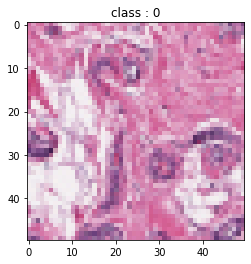

In [ ]:
img_sample = imread(class0[0])
plt.title("class : 0")
plt.imshow(img_sample)

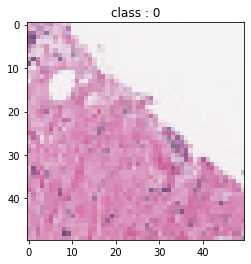

In [ ]:
img_sample = imread(class0[1])
plt.title("class : 0")
plt.imshow(img_sample)

In [ ]:
sampled_class0 = random.sample(class0, len(class1))
sampled_class1 = random.sample(class1, len(class1))

print("Class 0 :", len(sampled_class0))
print("Class 1 :", len(sampled_class1))

Class 0 : 78786
Class 1 : 78786


In [ ]:
def get_image_arrays(data, label):
    img_arrays = []
    for i in tqdm(range(len(data))):
        image = data[i]
        if image.endswith('.png'):
            img = cv2.imread(image ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [ ]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

del sampled_class0
del sampled_class1
del class0
del class1
del imagePatches

  0%|          | 0/78786 [00:00<?, ?it/s]

  0%|          | 0/78786 [00:00<?, ?it/s]

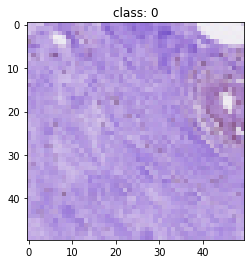

In [ ]:
img_sample = class0_array[0][0]
plt.title('class: 0')
plt.imshow(img_sample)

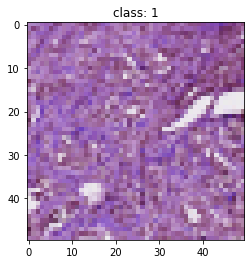

In [ ]:
img_sample = class1_array[0][0]
plt.title('class: 1')
plt.imshow(img_sample)

In [ ]:
combined_data = np.concatenate((class0_array, class1_array))

random.seed(18)
random.shuffle(combined_data)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)
    
del combined_data

In [ ]:
print(X[0])

[[[209 193 233]
  [204 185 231]
  [212 195 233]
  ...
  [239 236 242]
  [237 235 241]
  [210 203 227]]

 [[209 189 231]
  [207 186 231]
  [189 166 224]
  ...
  [240 239 242]
  [241 238 247]
  [239 235 242]]

 [[207 195 233]
  [193 169 223]
  [176 148 218]
  ...
  [238 235 243]
  [239 237 242]
  [240 239 241]]

 ...

 [[201 178 230]
  [196 171 228]
  [191 169 226]
  ...
  [175 143 223]
  [188 166 226]
  [184 158 224]]

 [[194 172 229]
  [199 178 229]
  [196 176 226]
  ...
  [185 163 226]
  [195 172 227]
  [206 187 234]]

 [[195 168 231]
  [191 166 229]
  [196 171 227]
  ...
  [179 149 218]
  [187 164 230]
  [199 176 230]]]


In [ ]:
X = np.array(X)
y = np.array(y)

print(" Shape X : ", X.shape)
print(" Shape y : ", y.shape)

 Shape X :  (157572, 50, 50, 3)
 Shape y :  (157572,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=18)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

np.save("X_train.npy" , X_train,)
np.save("X_val.npy" , X_val,)
np.save("y_train.npy" , y_train,)
np.save("y_val.npy" , y_val,)
del X,y

print(" X_train : ", X_train.shape)
print(" y_train : ", y_train.shape)
print(" X_val : ", y_train.shape)
print(" y_tval : ", y_val.shape)

 X_train :  (126057, 50, 50, 3)
 y_train :  (126057, 2)
 X_val :  (126057, 2)
 y_tval :  (31515, 2)


In [ ]:
"""X_train = np.load("./X_train.npy")
X_val = np.load("./X_val.npy")
y_train = np.load("./y_train.npy")
y_val = np.load('./y_val.npy')

print(" X_train : ", X_train.shape)
print(" y_train : ", y_train.shape)
print(" X_val : ", X_val.shape)
print(" y_tval : ", y_val.shape)"""

'X_train = np.load("./X_train.npy")\nX_val = np.load("./X_val.npy")\ny_train = np.load("./y_train.npy")\ny_val = np.load(\'./y_val.npy\')\n\nprint(" X_train : ", X_train.shape)\nprint(" y_train : ", y_train.shape)\nprint(" X_val : ", X_val.shape)\nprint(" y_tval : ", y_val.shape)'

In [ ]:
base_model_VGG = tf.keras.applications.VGG16(
    input_shape=(50,50,3),
    include_top=False,
    weights="imagenet"
)

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model_resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(50,50,3),
)


94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
base_models = [base_model_resnet, base_model_VGG]

for base_model in base_models:
    for layer in base_model.layers[:-5]:
        layer.trainable=False

In [ ]:
# Building Model

def build_model(base_model,METRICS):
    model = tf.keras.Sequential([
        #tf.keras.layers.Input(shape=(None,50,50,3)),
        tf.keras.layers.Lambda(lambda x: x/255),
        #keras.layers.Lambda(lambda x: x/255),
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2,activation='softmax')
    ])
    
    
    model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)
#     try:
#         model.summary()
#     except: 
#         pass
    return model
    

In [ ]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    plt.show()

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=5)

def fit_model(base, name, epochs,METRICS):
    base_model = base_models[base]
    print(f"Training using {name} model")
    
    model = build_model(base_model,METRICS)
    
    history = model.fit(X_train, y_train,
                        batch_size=128,
                        validation_data=(X_val, y_val),
                        verbose = 1,epochs = 5,
                        callbacks=[lrd,mcp,es]
                       )
    
    model.summary()
    
    Train_Val_Plot(history)

Training using RESNET50 model
Epoch 1/5
985/985 [==============================] - 41s 34ms/step - loss: 0.3577 - accuracy: 0.8591 - precision: 0.8591 - recall: 0.8591 - auc: 0.9200 - val_loss: 0.8646 - val_accuracy: 0.4276 - val_precision: 0.4276 - val_recall: 0.4276 - val_auc: 0.4447
Epoch 2/5
985/985 [==============================] - 31s 32ms/step - loss: 0.3280 - accuracy: 0.8665 - precision: 0.8665 - recall: 0.8665 - auc: 0.9319 - val_loss: 0.3452 - val_accuracy: 0.8553 - val_precision: 0.8553 - val_recall: 0.8553 - val_auc: 0.9301
Epoch 3/5
985/985 [==============================] - 32s 32ms/step - loss: 0.3252 - accuracy: 0.8688 - precision: 0.8688 - recall: 0.8688 - auc: 0.9326 - val_loss: 0.5858 - val_accuracy: 0.6916 - val_precision: 0.6916 - val_recall: 0.6916 - val_auc: 0.7603
Epoch 4/5
985/985 [==============================] - 31s 32ms/step - loss: 0.3212 - accuracy: 0.8682 - precision: 0.8682 - recall: 0.8682 - auc: 0.9344 - val_loss: 0.3526 - val_accuracy: 0.8565 - val

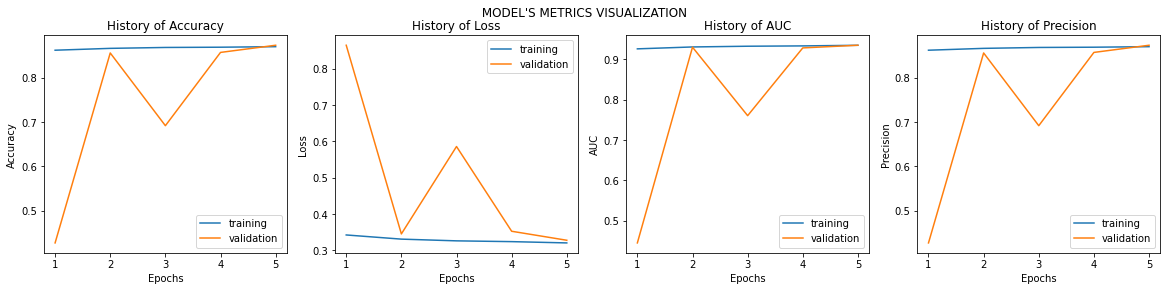

In [ ]:
fit_model(0, "RESNET50", 5,METRICS)

Training using VGG model
Epoch 1/5
985/985 [==============================] - 33s 32ms/step - loss: 0.3323 - accuracy: 0.8766 - precision: 0.8766 - recall: 0.8766 - auc: 0.9383 - val_loss: 0.2587 - val_accuracy: 0.8956 - val_precision: 0.8956 - val_recall: 0.8956 - val_auc: 0.9575
Epoch 2/5
985/985 [==============================] - 31s 31ms/step - loss: 0.2506 - accuracy: 0.8991 - precision: 0.8991 - recall: 0.8991 - auc: 0.9585 - val_loss: 0.2457 - val_accuracy: 0.9015 - val_precision: 0.9015 - val_recall: 0.9015 - val_auc: 0.9595
Epoch 3/5
985/985 [==============================] - 31s 31ms/step - loss: 0.2324 - accuracy: 0.9071 - precision: 0.9071 - recall: 0.9071 - auc: 0.9632 - val_loss: 0.2437 - val_accuracy: 0.9040 - val_precision: 0.9040 - val_recall: 0.9040 - val_auc: 0.9624
Epoch 4/5
985/985 [==============================] - 31s 31ms/step - loss: 0.2105 - accuracy: 0.9170 - precision: 0.9170 - recall: 0.9170 - auc: 0.9686 - val_loss: 0.2355 - val_accuracy: 0.9070 - val_prec

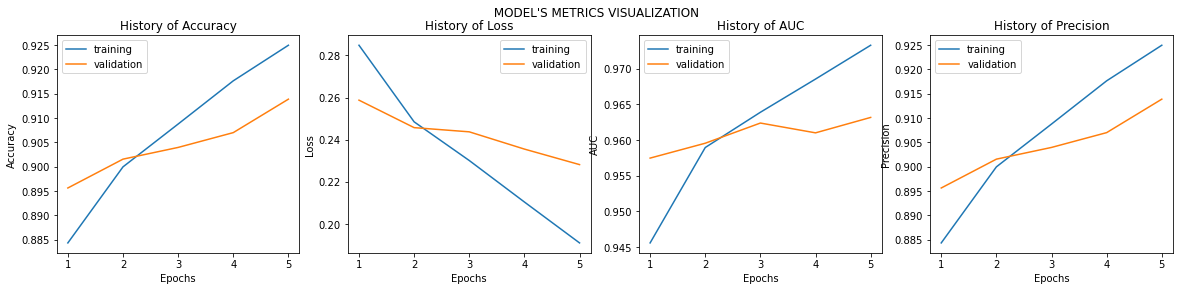

In [ ]:
fit_model(1, "VGG", 5, METRICS)